In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

filename1 = 'results_subgroups.csv'
filename2 = 'results_group-embedding.csv'

In [2]:
df_hybrid_subgroups = pd.read_csv(filename1)
df_hybrid_principal_components = pd.read_csv(filename2)

rest_of_algs = ['micro-level', 'pca+pcmci', 'pca+dynotears']
rest_of_dfs = [pd.read_csv(f'results_{name}.csv') for name in rest_of_algs]

In [3]:
df_hybrid_subgroups['explained_variance_threshold'] = [eval(params)['explained_variance_threshold'] for params in df_hybrid_subgroups['dimensionality_reduction_params']]
df_hybrid_subgroups.to_csv(filename1, index=False)

df_hybrid_principal_components['explained_variance_threshold'] = [eval(params)['explained_variance_threshold'] for params in df_hybrid_principal_components['dimensionality_reduction_params']]
df_hybrid_principal_components.to_csv(filename2, index=False)

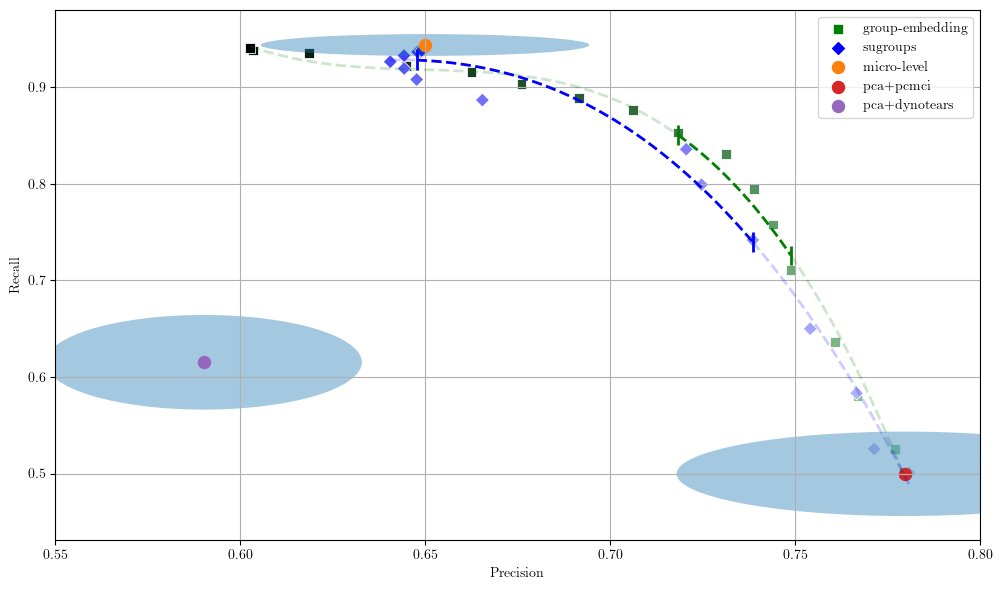

In [4]:
import itertools
import numpy as np
import seaborn as sns
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(10, 6))
plt.grid(True)

def plot_pareto_aproximation(df, x_label, y_label, ax, label, palette, color, marker, left_explained_variance=0.6, right_explained_variance=0.4):
    df_averaged = df.groupby(['dataset_iteration']).mean(numeric_only=True).reset_index()
    regresion = np.poly1d(np.polyfit(df_averaged[x_label], df_averaged[y_label], 3))
    def plot_aproximation(left_value, right_value, alpha, label=''):
        plt.plot(x_values:=np.linspace(left_value, right_value),
            regresion(x_values),
            linewidth=2, color=color, linestyle='--', alpha=alpha, label=label)
    def plot_cut(point_x):
        ax.vlines(point_x,
                      regresion(point_x) - 0.01,
                      regresion(point_x) + 0.01,
                      linestyles='-',
                      linewidth=2,
                      color=color)
    
    # Here we plot a interval between that has explained_variance_threshold between left and right values
    # First we get left and right points
    left_point = df_averaged[df_averaged['explained_variance_threshold'] == left_explained_variance]
    right_point = df_averaged[df_averaged['explained_variance_threshold'] == right_explained_variance]
    plot_cut(left_point[x_label])
    plot_cut(right_point[x_label])
    
    # Now we plot the aproximation of the pareto front in the left and tight interval, both with low alpha
    plot_aproximation(df_averaged[x_label].min(), left_point[x_label], alpha=0.2)
    plot_aproximation(right_point[x_label], df_averaged[x_label].max(), alpha=0.2)
    
    # And plot inner interval with higher alpha
    plot_aproximation(left_point[x_label], right_point[x_label], alpha=1)
    
    # Now plot points
    sns.scatterplot(data=df_averaged, x=x_label, y=y_label,
                    hue='explained_variance_threshold', s=50,
                    ax=ax, legend=False, palette=palette, marker=marker)
    
    # And show the label with the color of the line
    plt.scatter([], [], color=color, label=label, marker=marker)




plot_pareto_aproximation(df_hybrid_principal_components, x_label='precision', y_label='recall', ax=ax,
                         label='group-embedding',  color='green', marker='s',
                         palette=sns.cubehelix_palette(start=2, rot=0, dark=0, light=.9, as_cmap=True),)
plot_pareto_aproximation(df_hybrid_subgroups, x_label='precision', y_label='recall', ax=ax,
                         label='sugroups',  color='blue', marker='D',
                         palette='light:blue')


# Plot the points outside of the pareto front
color_cycle = itertools.cycle(['tab:orange', 'tab:red', 'tab:purple'])
for alg, df in zip(rest_of_algs, rest_of_dfs):
    precision = df['precision'].mean()
    precision_std = df['precision'].std()
    recall = df['recall'].mean()
    recall_std = df['recall'].std()
    
    ax.add_patch( Ellipse(xy=(precision, recall), width=precision_std, height=recall_std,
            alpha=0.4) )
    plt.scatter([precision], [recall], label=alg, marker='o', s=75, color=next(color_cycle))

    

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()
# plt.axis('equal')
plt.tight_layout()
plt.xlim(0.55, 0.8)
# plt.ylim(0.3, 1)
plt.savefig('pareto_front_hybrid_varying_variance_threshold.pdf')

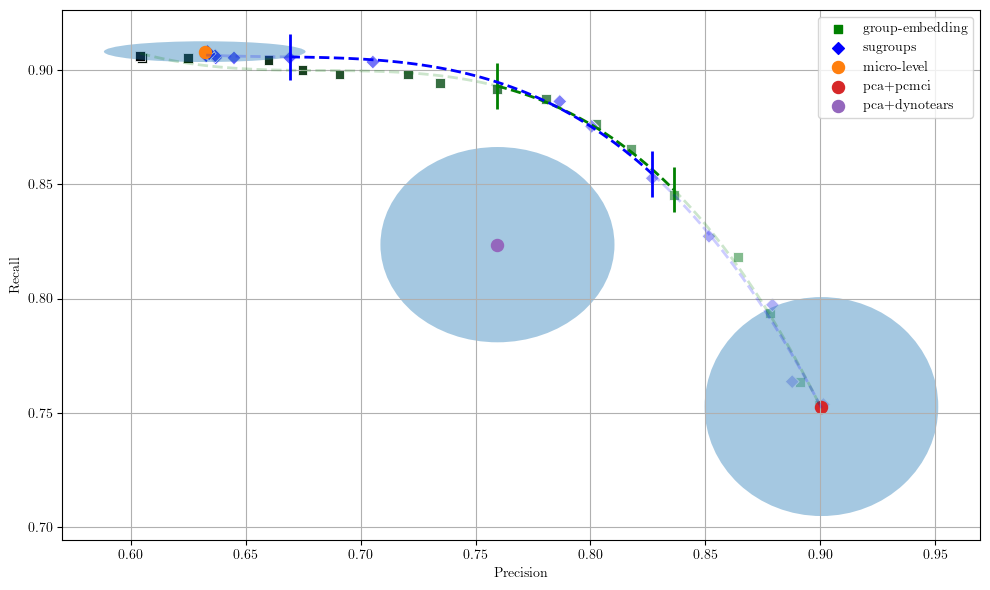

In [5]:
import numpy as np
import seaborn as sns
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(10, 6))
plt.grid(True)

plot_pareto_aproximation(df_hybrid_principal_components, x_label='precision_summary', y_label='recall_summary', ax=ax,
                         label='group-embedding',  color='green', marker='s',
                         palette=sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, as_cmap=True),
                         )
plot_pareto_aproximation(df_hybrid_subgroups, x_label='precision_summary', y_label='recall_summary', ax=ax,
                         label='sugroups',  color='blue', marker='D',
                         palette='light:blue')


# Plot the points outside of the pareto front
color_cycle = itertools.cycle(['tab:orange', 'tab:red', 'tab:purple'])
for alg, df in zip(rest_of_algs, rest_of_dfs):
    precision = df['precision_summary'].mean()
    precision_std = df['precision_summary'].std()
    recall = df['recall_summary'].mean()
    recall_std = df['recall_summary'].std()
    
    ax.add_patch( Ellipse(xy=(precision, recall), width=precision_std, height=recall_std,
            alpha=0.4) )
    plt.scatter([precision], [recall], label=alg, marker='o', s=75, color=next(color_cycle))
    


plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()
# plt.axis('equal')
plt.tight_layout()
# plt.xlim(0.6, 0.96)
# plt.ylim(0.3, 1)
plt.savefig('pareto_front_hybrid_varying_variance_threshold_summary.pdf')